# **Predict celltype-specific drug differences in sciplex+L1000 data**
In this notebook I use the models trained in the hyperparameter search in order to compare the performance of BuDDI in identifying which genes have the largest celltype-specific sex differences in the mouse liver.

Here I compare the inferred pseudobulked L1000 cell-type specific changes against drug differences in sciplex. 

We will focus on the results from the PR curve and want to identify the top genes at the top of our DE results lists. BuDDI should be more specific for each cell-type. 

We will use the same baselines as in the liver analysis.


# **Imports**

In [127]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata
from sklearn.metrics import average_precision_score, f1_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [128]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_sciplex_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/augmented_l1000_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_sciplex/"

de_bulk_path = f"{os.getcwd()}/../data/bulk_data/l1000/de_l1000_pseudobulk_results.pkl"
de_sc_path = f"{os.getcwd()}/../data/single_cell_data/sciplex/de_pseudobulk_results.pkl"
cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_synovium/"



num_genes = 967

exp_id = "all-sciplex"
res_id = "trichostatin-sciplex"
curr_treatment = "trichostatin"

RETRAIN_MODELS = False
RUN_CIBERSORT_GENES = False
RUN_CIBERSORT_SAMPLES = False


# Set-up experimental variables

In [129]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 2

# number of patients/domains/samples expected
n_tot_samples = 2 # 16 bulk and 7 single cell samples -- Tocilizumab

# number of drugs (CTRL, Tocilizumab, Rituximab)
# one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [130]:
in_name = f"l1000_bulk_processed"


# read in the real bulk data

curr_samp = 'samp_l1000'
stim_order = ['CTRL', "STIM"]

real_bulk_df = None
real_bulk_Y = None
real_bulk_meta_df = None

for curr_stim in stim_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df1, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(bulk_aug_data_path, curr_samp, curr_stim, "Train", "all-l1000")
    pseudobulks_df.columns = gene_df1

    if real_bulk_df is None:
        real_bulk_df, real_bulk_Y, real_bulk_meta_df = pseudobulks_df, prop_df, metadata_df
    else:
        real_bulk_df = pd.concat([real_bulk_df, pseudobulks_df])
        real_bulk_Y = pd.concat([real_bulk_Y, prop_df])
        real_bulk_meta_df = pd.concat([real_bulk_meta_df, metadata_df])

real_bulk_Y.index = real_bulk_meta_df.index
real_bulk_meta_df = pd.concat([real_bulk_meta_df, real_bulk_Y], axis=1)



# now get the sc ref training data

# read in order
# oritinal samples
sample_order = ['samp1']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df2, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df2

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])



# select genes that are in both
intersect_genes = np.intersect1d(gene_df1, gene_df2)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted

# then add in other columns needed
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat,  real_bulk_Y ]) ## stop gap for now 

meta_df = pd.concat([meta_concat, real_bulk_meta_df])

# index for checking correlations
sc_idx = np.where(meta_df.samp_type != "bulk")[0]
bulk_idx = np.where(meta_df.samp_type == "bulk")[0]


samp_l1000
samp_l1000
samp1


### format sample indicies and get variable genes

In [131]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim != "CTRL")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()


### normalize

In [132]:
# check correlation between bulk and single cell
# we want them to be similar between bulk+sc and within bulk
sc_check = sc_idx[0]
bulk_check = bulk_idx[0]
print(np.corrcoef((X_full.iloc[sc_check] / np.sum(X_full.iloc[sc_check])), (X_full.iloc[bulk_check] / np.sum(X_full.iloc[bulk_check]))))

bulk_check = bulk_idx[1]
print(np.corrcoef((X_full.iloc[sc_check] / np.sum(X_full.iloc[sc_check])), (X_full.iloc[bulk_check] / np.sum(X_full.iloc[bulk_check]))))


bulk_check = bulk_idx[2]
print(np.corrcoef((X_full.iloc[sc_check] / np.sum(X_full.iloc[sc_check])), (X_full.iloc[bulk_check] / np.sum(X_full.iloc[bulk_check]))))


bulk_check = bulk_idx[5]
print(np.corrcoef((X_full.iloc[sc_check] / np.sum(X_full.iloc[sc_check])), (X_full.iloc[bulk_check] / np.sum(X_full.iloc[bulk_check]))))


bulk_check = bulk_idx[12]
print(np.corrcoef((X_full.iloc[sc_check] / np.sum(X_full.iloc[sc_check])), (X_full.iloc[bulk_check] / np.sum(X_full.iloc[bulk_check]))))

[[1.         0.20318692]
 [0.20318692 1.        ]]
[[1.        0.1899128]
 [0.1899128 1.       ]]
[[1.         0.21446927]
 [0.21446927 1.        ]]
[[1.         0.20795978]
 [0.20795978 1.        ]]
[[1.         0.20058783]
 [0.20058783 1.        ]]


In [133]:

# rescale sc_ref and bulks
median_sc_ref = np.median(np.quantile(X_full.iloc[sc_idx], axis=1, q=0.9))
median_bulk = np.median(np.quantile(X_full.iloc[bulk_idx], axis=1, q=0.9))

#ratio_medians = median_bulk/median_sc_ref
ratio_medians = median_sc_ref/median_bulk

X_full.iloc[bulk_idx] = X_full.iloc[bulk_idx]*ratio_medians



## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
#X_full = scaler.transform(X_full)
from sklearn.preprocessing import minmax_scale
X_full = minmax_scale(X_full, axis=1)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


### plot data

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 11200 samples in 0.021s...
[t-SNE] Computed neighbors for 11200 samples in 1.789s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11200
[t-SNE] Computed conditional probabilities for sample 2000 / 11200
[t-SNE] Computed conditional probabilities for sample 3000 / 11200
[t-SNE] Computed conditional probabilities for sample 4000 / 11200
[t-SNE] Computed conditional probabilities for sample 5000 / 11200
[t-SNE] Computed conditional probabilities for sample 6000 / 11200
[t-SNE] Computed conditional probabilities for sample 7000 / 11200
[t-SNE] Computed conditional probabilities for sample 8000 / 11200
[t-SNE] Computed conditional probabilities for sample 9000 / 11200
[t-SNE] Computed conditional probabilities for sample 10000 / 11200
[t-SNE] Computed conditional probabilities for sample 11000 / 11200
[t-SNE] Computed conditional probabilities for sample 11200 / 11200
[t-SNE] Mean sigma: 0.168541
[t-SNE] KL divergence

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_65031/2884562472.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


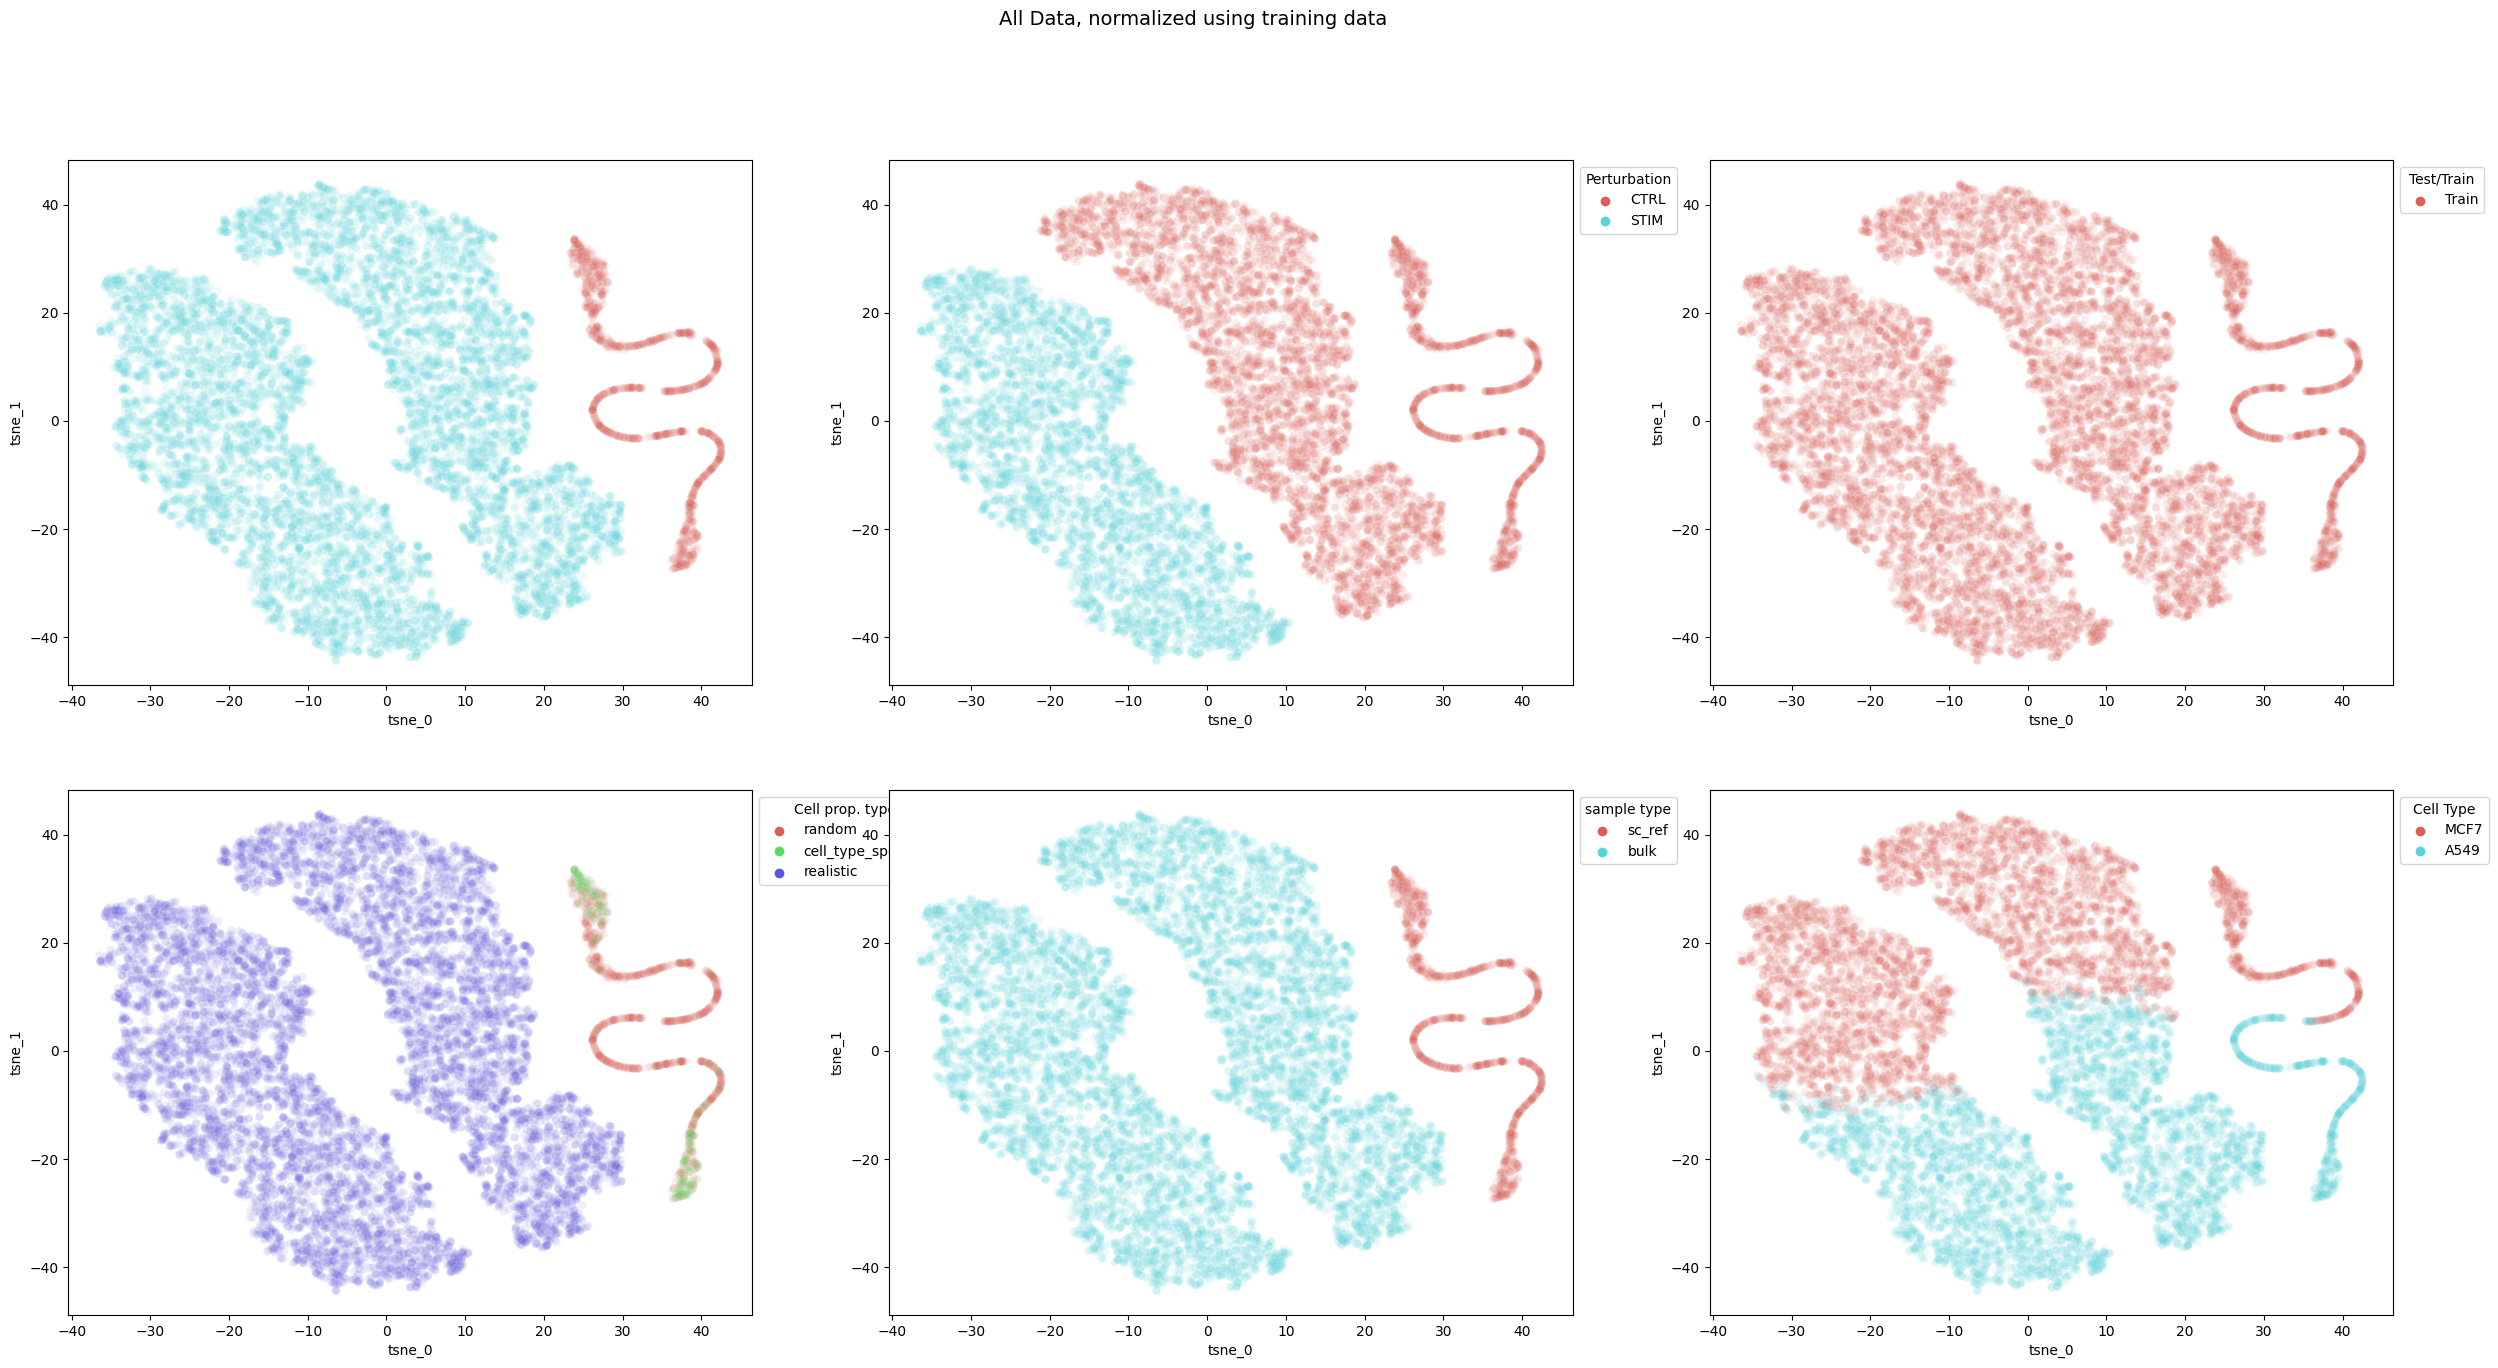

In [134]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

# this is a vector that represents the cell-type with 
# the highest proportion 
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]


vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(10000, 2)
(10000, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_65031/2821073111.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


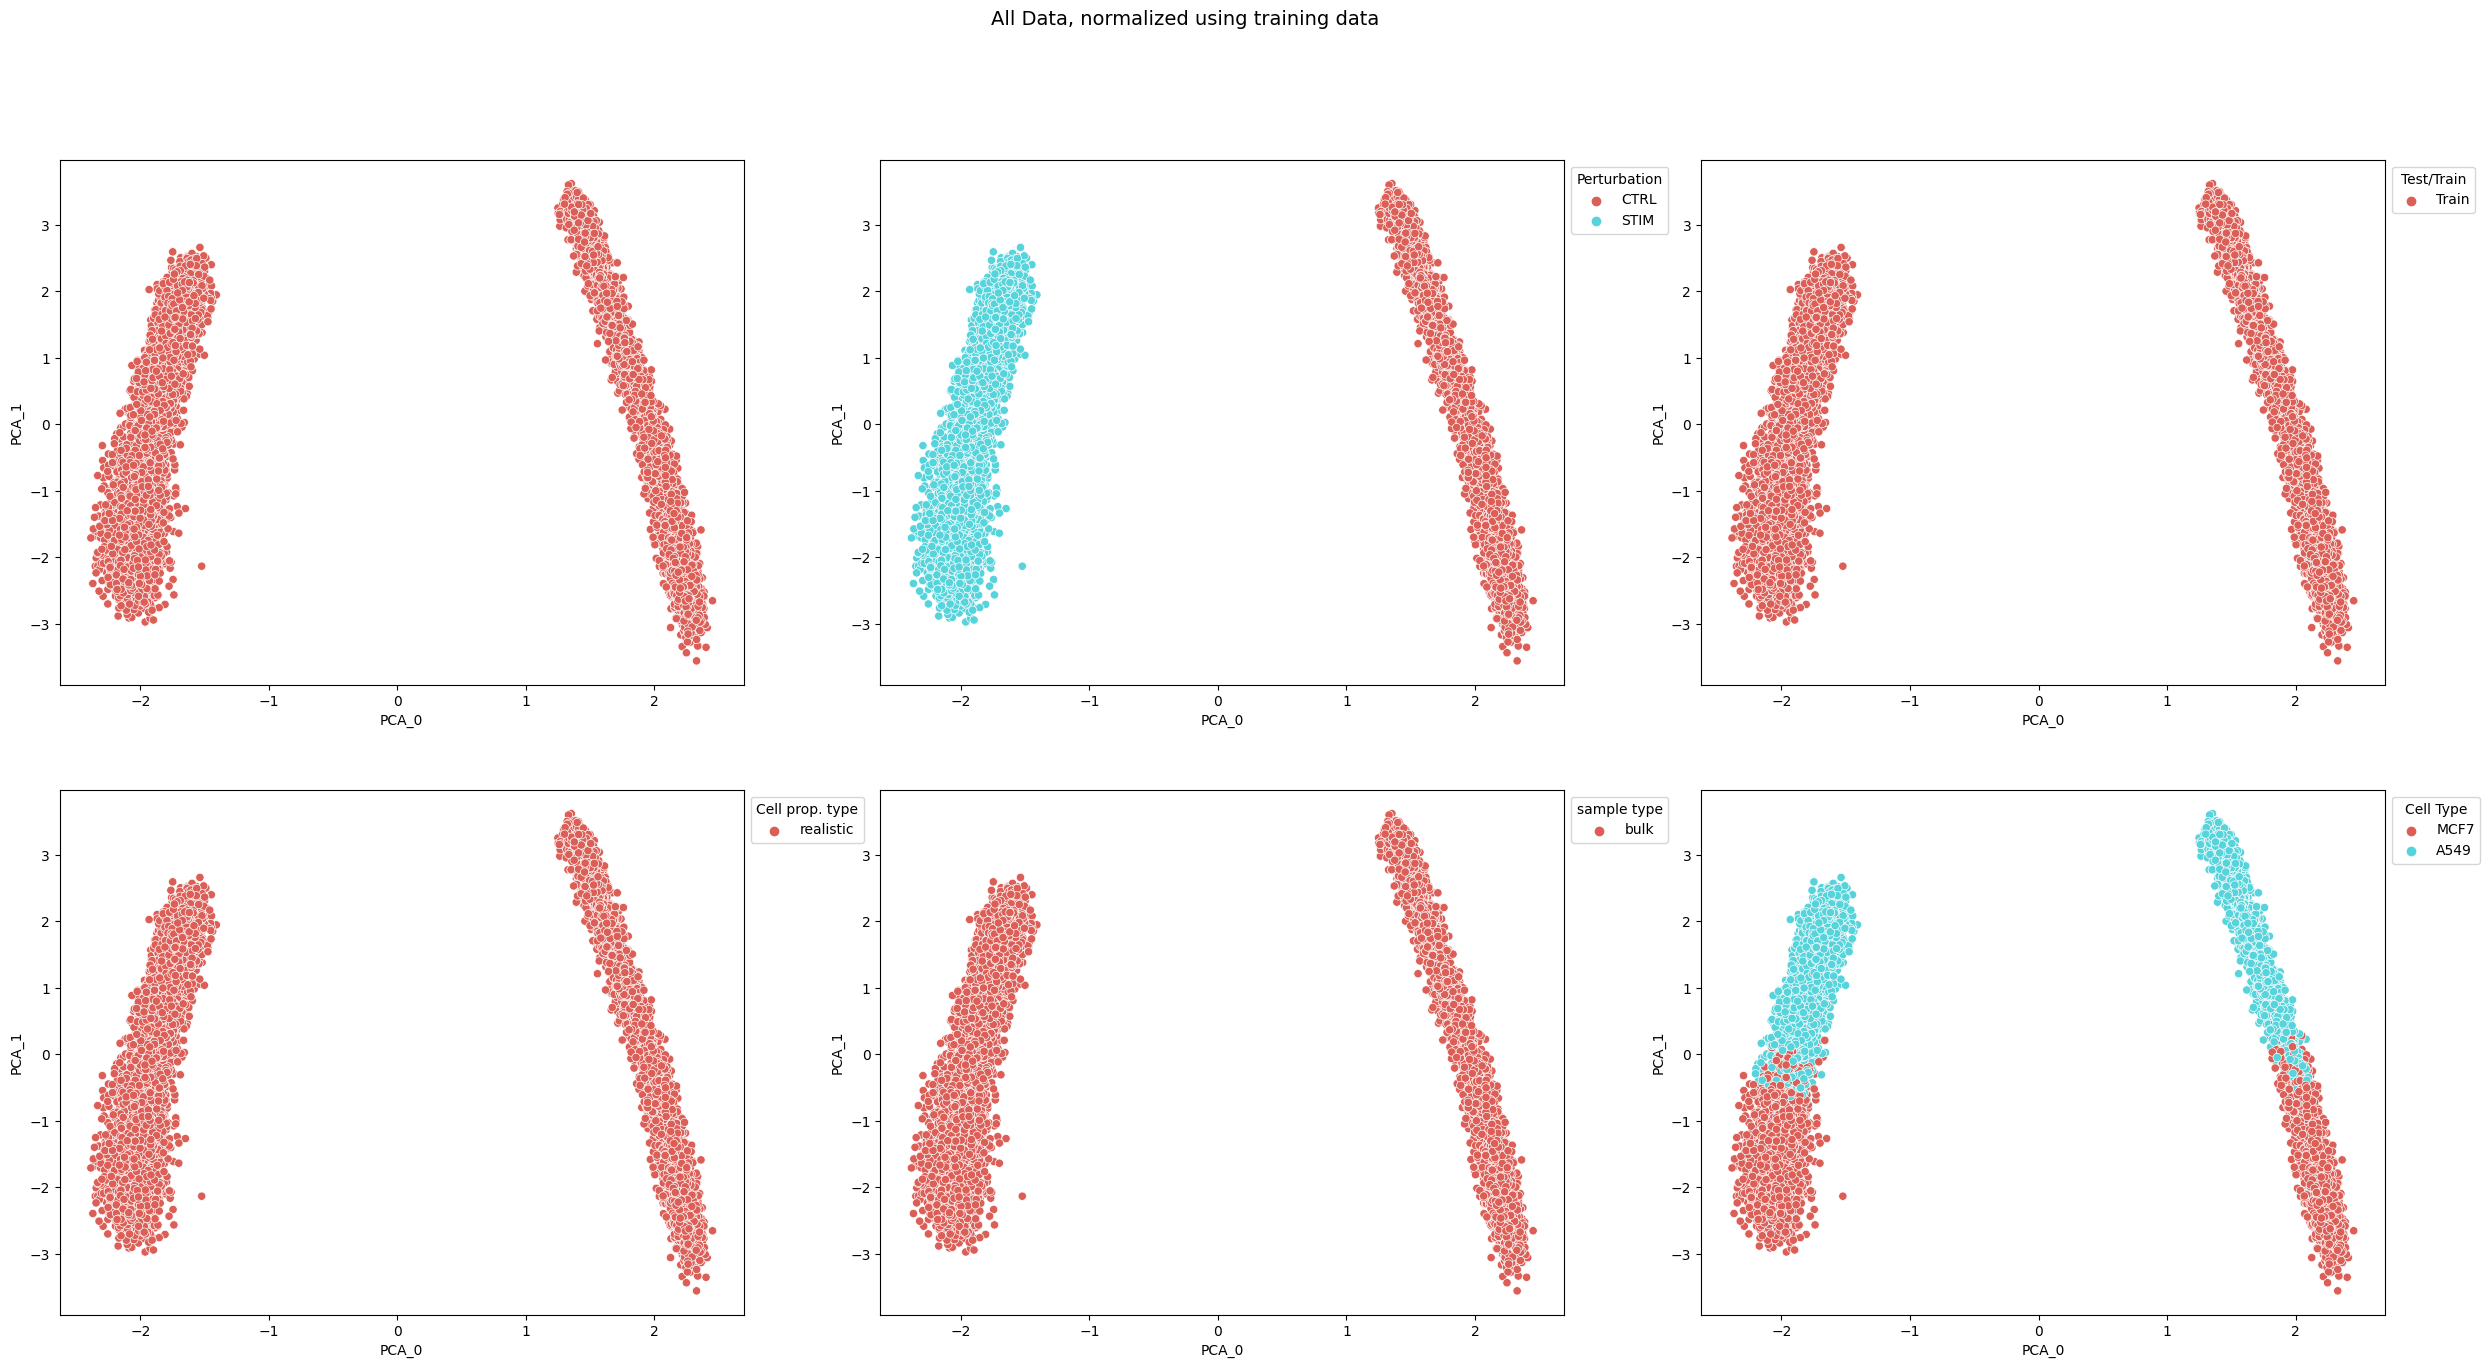

In [135]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1, legend_title="Sample ID")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1, legend_title="Perturbation")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1, legend_title="Test/Train")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1, legend_title="Cell prop. type")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1, legend_title="sample type")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.180742
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.911163
[t-SNE] KL divergence after 500 iterations: 2.130097
(10000, 2)
(10000, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_65031/2955274557.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


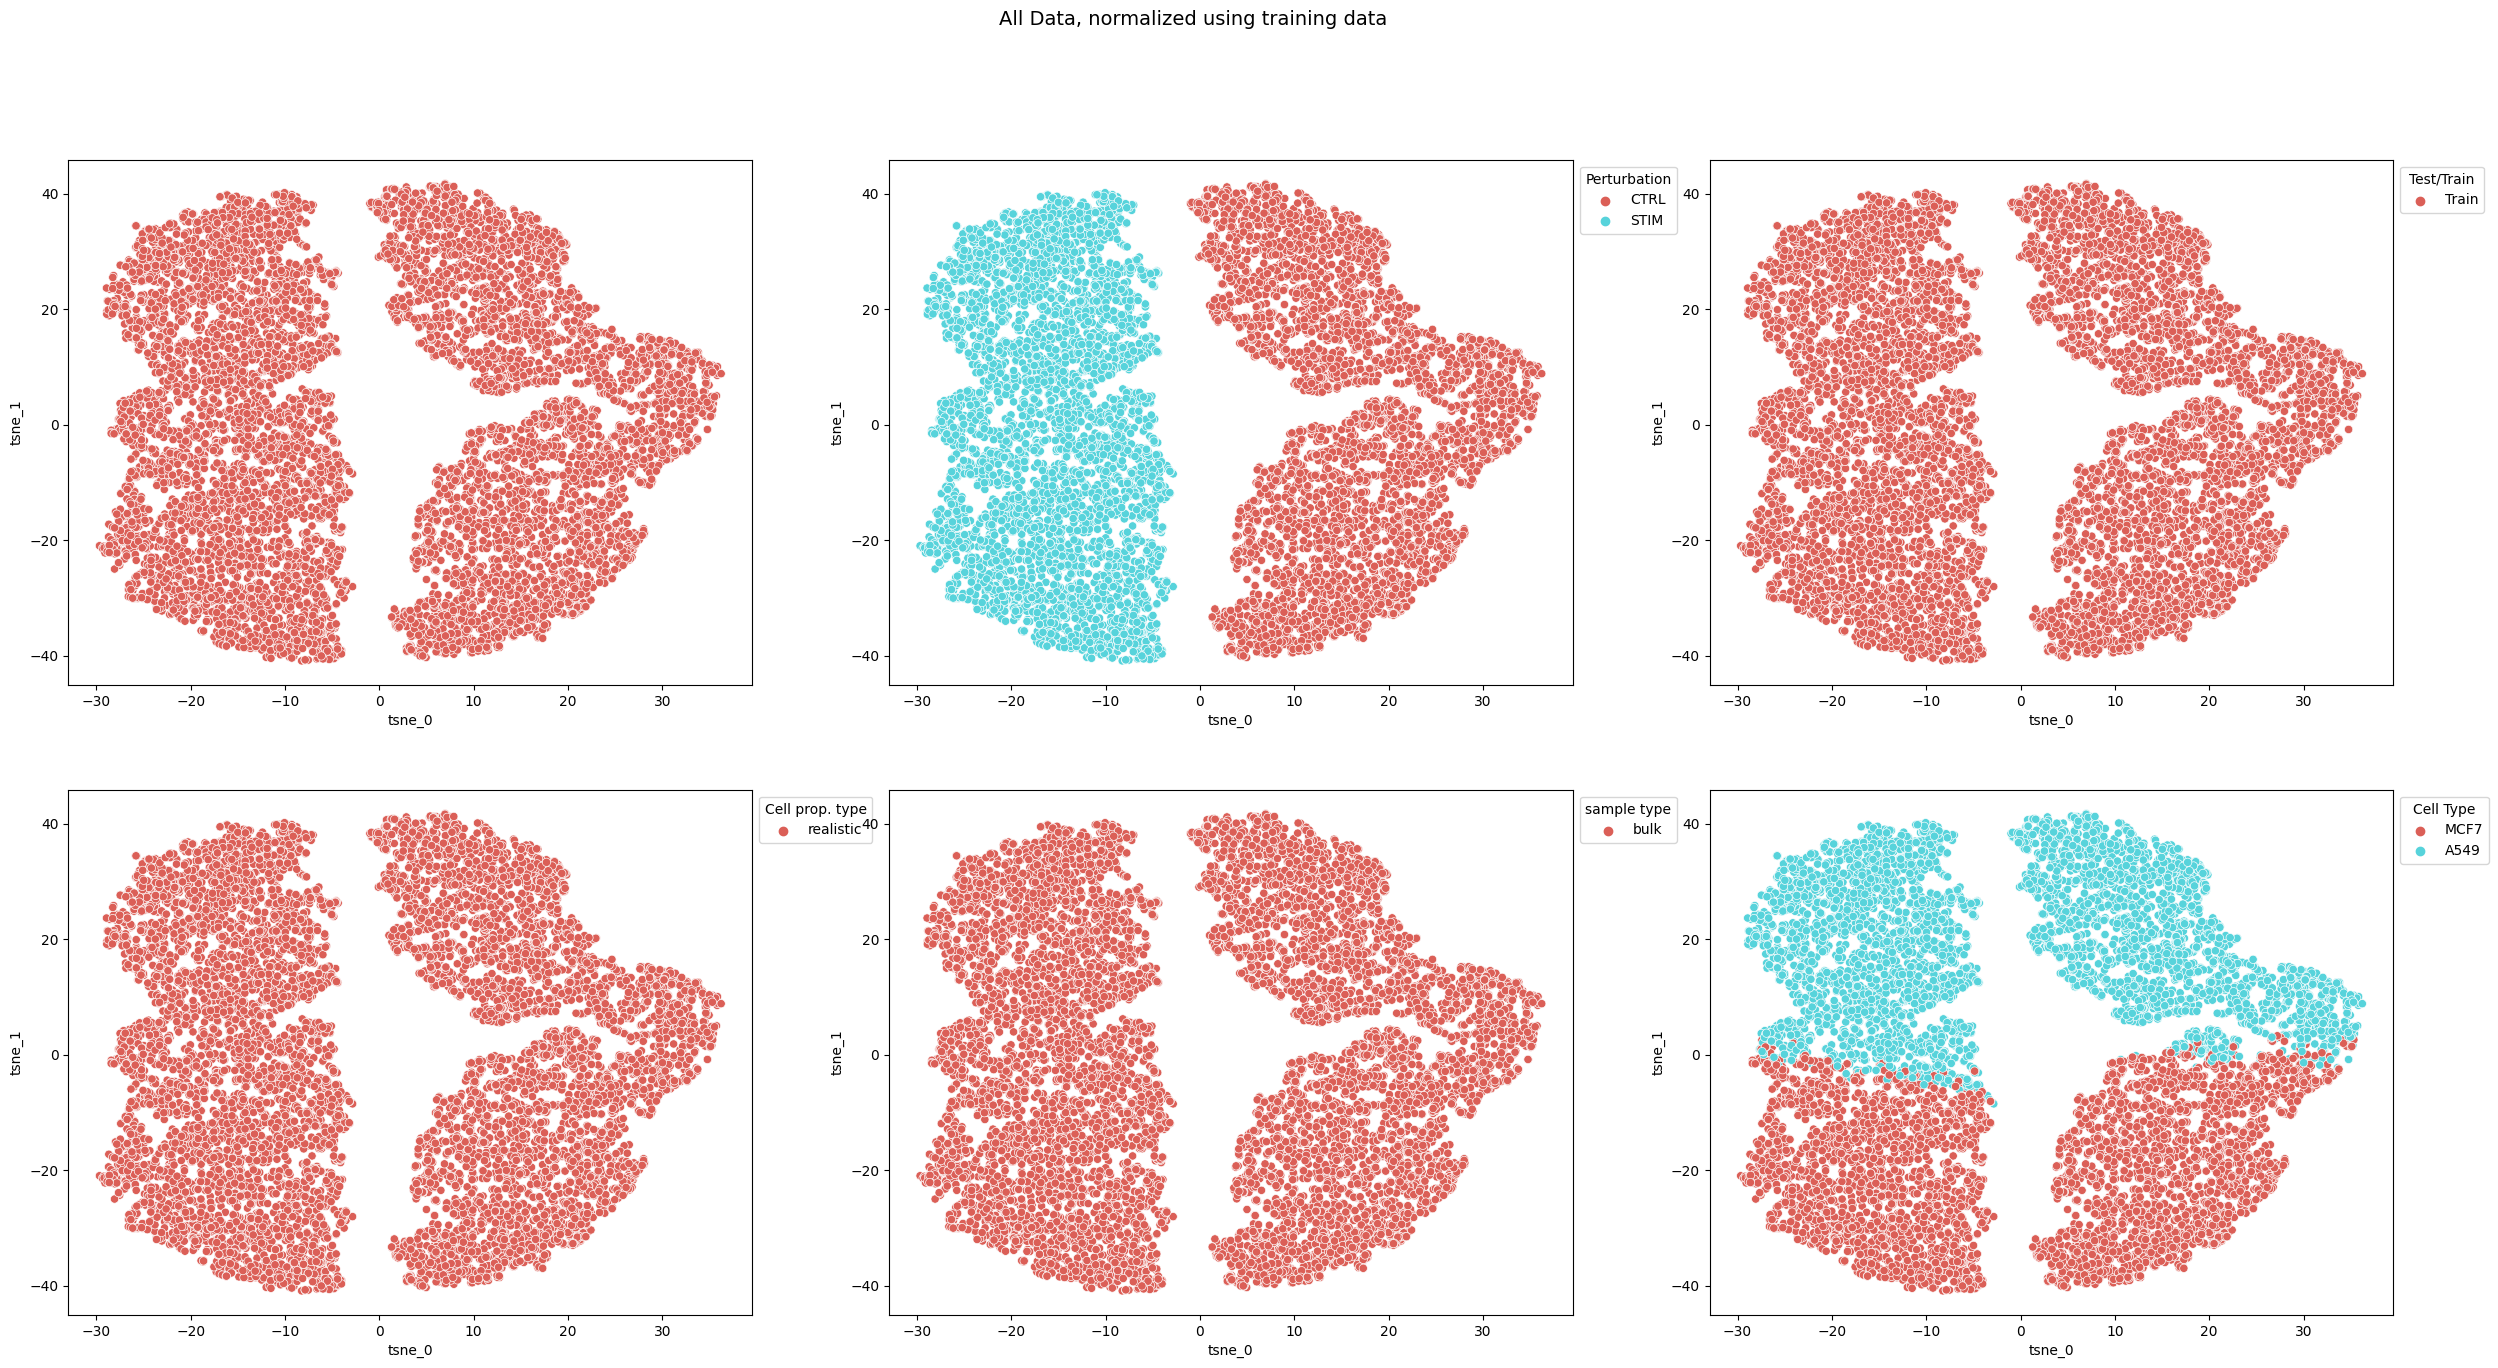

In [136]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], alpha=1, title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], alpha=1, title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], alpha=1, title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], alpha=1, title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], alpha=1, title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Read in Trained Models**

In [137]:

res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model1_{res_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model1_{res_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model1_{res_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model1_{res_id}_classifier")


res2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model2_{res_id}_encoder_unlab")
res2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model2_{res_id}_encoder_lab")
res2_dec = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model2_{res_id}_decoder")
res2_classifier = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model2_{res_id}_classifier")


res3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model3_{res_id}_encoder_unlab")
res3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model3_{res_id}_encoder_lab")
res3_dec = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model3_{res_id}_decoder")
res3_classifier = tf.keras.models.load_model(f"{res_data_path}/trichostatin_model3_{res_id}_classifier")


2024-08-26 09:37:52.265510: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_522' id:8617 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_522}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_261, Identity_522)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:37:56.452618: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_558' id:9024 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_558}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_277, Identity_558)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:37:59.932995: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_571' id:9194 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_571}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_285, Identity_571)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:38:01.862103: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_576' id:9281 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_576}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_288, Identity_576)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:38:03.519170: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_594' id:9572 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_594}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_295, Identity_594)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:38:05.252195: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_623' id:9965 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_623}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_309, Identity_623)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:38:06.507979: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_628' id:10119 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_628}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_314, Identity_628)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:38:07.863848: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_633' id:10206 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_633}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_316, Identity_633)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:38:09.719535: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_654' id:10503 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_654}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_325, Identity_654)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:38:11.649754: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_664' id:10858 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_664}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_332, Identity_664)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:38:14.169254: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_688' id:11050 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_688}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_344, Identity_688)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-08-26 09:38:16.584262: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_690' id:11131 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_690}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_345, Identity_690)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Do latent space projectsions

### drug perturbation

In [138]:
gene_df.to_list()

['AARS',
 'ABCB6',
 'ABCC5',
 'ABCF1',
 'ABCF3',
 'ABHD4',
 'ABHD6',
 'ABL1',
 'ACAA1',
 'ACAT2',
 'ACBD3',
 'ACD',
 'ACLY',
 'ACOT9',
 'ADAM10',
 'ADAT1',
 'ADGRE5',
 'ADGRG1',
 'ADH5',
 'ADI1',
 'ADO',
 'ADRB2',
 'AGL',
 'AKAP8',
 'AKAP8L',
 'AKR7A2',
 'AKT1',
 'ALAS1',
 'ALDH7A1',
 'ALDOA',
 'ALDOC',
 'AMDHD2',
 'ANKRD10',
 'ANO10',
 'ANXA7',
 'APBB2',
 'APOE',
 'APP',
 'APPBP2',
 'ARFIP2',
 'ARHGAP1',
 'ARHGEF12',
 'ARHGEF2',
 'ARID4B',
 'ARID5B',
 'ARL4C',
 'ARNT2',
 'ARPP19',
 'ASAH1',
 'ASCC3',
 'ATF1',
 'ATF5',
 'ATF6',
 'ATG3',
 'ATMIN',
 'ATP11B',
 'ATP1B1',
 'ATP2C1',
 'ATP5S',
 'ATP6V0B',
 'ATP6V1D',
 'AURKA',
 'AURKB',
 'AXIN1',
 'B4GAT1',
 'BACE2',
 'BAD',
 'BAG3',
 'BAMBI',
 'BAX',
 'BCL2',
 'BCL7B',
 'BDH1',
 'BECN1',
 'BHLHE40',
 'BID',
 'BIRC2',
 'BIRC5',
 'BLCAP',
 'BLMH',
 'BLVRA',
 'BMP4',
 'BNIP3',
 'BNIP3L',
 'BPHL',
 'BRCA1',
 'BTK',
 'BUB1B',
 'BZW2',
 'C2CD2',
 'C2CD2L',
 'C2CD5',
 'C5',
 'CAB39',
 'CALM3',
 'CALU',
 'CAMSAP2',
 'CANT1',
 'CAPN1',
 'CASC3',
 '

In [139]:

res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, res1_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res1_enc_unlab, res1_dec, batch_size=500, 
                                                                            genes_ordered=gene_df.to_list(), 
                                                                            top_lim=100, use_buddi4=True)


res2_meta_df, res2_decoded_0_0, res2_decoded_0_1, res2_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res2_enc_unlab, res2_dec, batch_size=500, 
                                                                            genes_ordered=gene_df.to_list(), 
                                                                            top_lim=100, use_buddi4=True)


res3_meta_df, res3_decoded_0_0, res3_decoded_0_1, res3_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res3_enc_unlab, res3_dec, batch_size=500, 
                                                                            genes_ordered=gene_df.to_list(), 
                                                                            top_lim=100, use_buddi4=True)


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-08-26 09:38:18.435944: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack_8/add/z_samp_slack_8/add' id:8736 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack_8/add/z_samp_slack_8/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dependencies=true](mu_slack_18/BiasAdd, tf_op_layer_z_samp_slack_8/mul/z_samp_slack_8/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/davidnat/Documents/projects/greenelab/buddi/buddi/buddi.py:893: SettingWit

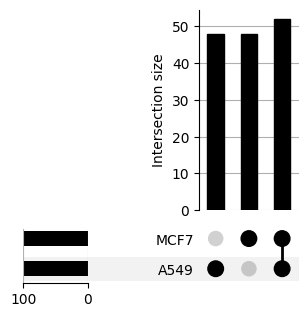

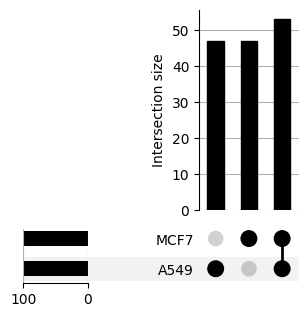

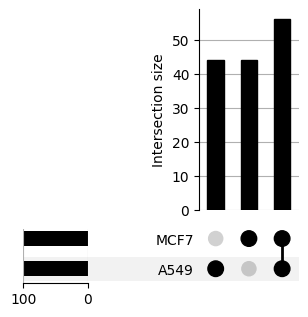

In [140]:
# identify how cell-type specific the DE genes are
cell_diff = from_contents(res1_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

cell_diff = from_contents(res2_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

cell_diff = from_contents(res3_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()


### load bulk DE results

In [141]:
de_bulk_path

'/Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/l1000_sciplex_analysis/../data/bulk_data/l1000/de_l1000_pseudobulk_results.pkl'

In [142]:
de_bulk = pickle.load(open( de_bulk_path, "rb" ))
de_bulk = de_bulk["pseudobulk"]
de_bulk.index = [x.upper() for x in de_bulk.index] 
de_bulk = de_bulk.iloc[np.where(de_bulk.padj < 1)[0]]
intersect_bulk = np.intersect1d(de_bulk.index.to_list(), gene_df)

bulk_sig_df = pd.DataFrame(gene_df, index=gene_df)
bulk_sig_df["padj"] = 1
padj_val = de_bulk.padj[intersect_bulk]
bulk_sig_df.padj.loc[intersect_bulk] = padj_val

bulk_sig_df["log10padj"] = -1*np.log10(bulk_sig_df.padj)

bulk_sig_df["log2FC"] = 1
fc_val = de_bulk.log2FoldChange[intersect_bulk]
bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)

bulk_sig_df["gene_ids"] = bulk_sig_df.index
bulk_sig_df

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_65031/1352006596.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.padj.loc[intersect_bulk] = padj_val
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_65031/1352006596.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.log2FC.loc[intersect_bulk] = np.abs(fc_val)


gene_ids          padj  log10padj    log2FC
gene_ids                                            
AARS         AARS  1.789351e-27  26.747304  0.064580
ABCB6       ABCB6  1.843692e-37  36.734312  0.080341
ABCC5       ABCC5  2.471126e-02   1.607105  0.031798
ABCF1       ABCF1  8.503020e-16  15.070427  0.050835
ABCF3       ABCF3  3.330904e-64  63.477438  0.165238
...           ...           ...        ...       ...
ZNF395     ZNF395  2.010652e-03   2.696663  0.036561
ZNF451     ZNF451  9.961329e-61  60.001683  0.057852
ZNF586     ZNF586  2.364138e-01   0.626327  0.027372
ZNF589     ZNF589  2.110297e-01   0.675656  0.014333
ZW10         ZW10  4.666383e-51  50.331020  0.112723

[967 rows x 4 columns]

### load single-cell DE genes result

In [143]:
de_sc_path

'/Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/l1000_sciplex_analysis/../data/single_cell_data/sciplex/de_pseudobulk_results.pkl'

In [144]:
de_genes = pickle.load(open( de_sc_path, "rb" ))
len(de_genes["A549"])

894

In [145]:
de_genes["A549"]

['FAM20B',
 'SNX6',
 'ARID4B',
 'CSNK1A1',
 'SYNE2',
 'DNMT1',
 'CDK6',
 'SLC25A13',
 'USP22',
 'TCERG1',
 'LYPLA1',
 'TSEN2',
 'RAB21',
 'RAB31',
 'NFE2L2',
 'ASAH1',
 'DNM1',
 'DCUN1D4',
 'HES1',
 'PSMD4',
 'ECH1',
 'MBNL2',
 'BAX',
 'ENOSF1',
 'HSPA8',
 'REEP5',
 'ARL4C',
 'PYGL',
 'MYBL2',
 'HPRT1',
 'PAK1',
 'TPM1',
 'MAN2B1',
 'HAT1',
 'POLR2I',
 'ZNF274',
 'HS2ST1',
 'EIF4G1',
 'PDIA5',
 'ABL1',
 'SMC3',
 'PMM2',
 'NFATC3',
 'MAP3K4',
 'TM9SF2',
 'GLI2',
 'HK1',
 'RBM6',
 'HACD3',
 'HIF1A',
 'HEATR1',
 'RNF167',
 'TM9SF3',
 'APPBP2',
 'RRP1B',
 'INTS3',
 'COASY',
 'USP6NL',
 'NCK1',
 'IGF2BP2',
 'LYN',
 'RAP1GAP',
 'CDC25B',
 'SMC4',
 'PTPN12',
 'ITGB5',
 'PTPRF',
 'PARP1',
 'PIK3C2B',
 'TOP2A',
 'ZNF586',
 'MBNL1',
 'TIMP2',
 'MAP4K4',
 'PCM1',
 'EVL',
 'ORC1',
 'VAV3',
 'EPN2',
 'KIAA0355',
 'SPAG7',
 'IL13RA1',
 'BMP4',
 'IDE',
 'MELK',
 'CREG1',
 'OXSR1',
 'SDHB',
 'ITFG1',
 'FBXO11',
 'PAICS',
 'ZNF451',
 'GPC1',
 'TBC1D31',
 'BZW2',
 'AARS',
 'CTSD',
 'EPRS',
 'RFC5',
 'MA

In [146]:
from matplotlib_venn import venn3
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve
from random import sample

sns.set_palette("Set2")

# get PR curve

def plot_PR_ROC(ctrl_test_meta_df, decoded_0_0, decoded_0_1, de_bulk_genes, curr_cell_type, sc_DE_ref, axs, union_genes_cap):

    # this is for the "projected" expression
    curr_idx = np.where(ctrl_test_meta_df.Y_max == curr_cell_type)[0]
    proj_ctrl = decoded_0_0[curr_idx]
    proj_stim = decoded_0_1[curr_idx]

    # take the median for nomalization
    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    proj_log2FC = abs(proj_stim-proj_ctrl)

    # make dataframe of true/false positives
    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=union_genes_cap)
    proj_log2FC_df["orig"] = proj_stim-proj_ctrl

    # make a random one
    proj_log2FC_df["random"] = sample(proj_log2FC_df[0].tolist(), len(proj_log2FC_df[0].tolist()))

    # compare with bulk alone
    proj_log2FC_df["bulk"] = np.abs(de_bulk_genes.log2FC.loc[union_genes_cap])

    # compare with our ground truth
    proj_log2FC_df["sc_DE"] = 0
    proj_log2FC_df.sc_DE[np.where(np.isin(gene_df, sc_DE_ref[curr_cell_type][::-1][0:50]))[0]] = 1

    # now do the single-cell cell type specific DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.sc_DE, proj_log2FC_df[0], name="BuDDI", ax=axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.sc_DE, proj_log2FC_df[0], name="BuDDI", ax=axs[0,1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.sc_DE, proj_log2FC_df.random, name="random",ax= axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.sc_DE, proj_log2FC_df.random, name="random", ax=axs[0,1])

    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.sc_DE, proj_log2FC_df.bulk, name="bulk",ax= axs[0,0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.sc_DE, proj_log2FC_df.bulk, name="bulk", ax=axs[0,1])

    sn_avg_pr_BuDDI = average_precision_score(proj_log2FC_df.sc_DE, proj_log2FC_df[0])
    sn_avg_pr_random = average_precision_score(proj_log2FC_df.sc_DE, proj_log2FC_df.random)
    sn_avg_pr_bulk = average_precision_score(proj_log2FC_df.sc_DE, proj_log2FC_df.bulk)

    res_df = pd.DataFrame([sn_avg_pr_BuDDI, sn_avg_pr_random, sn_avg_pr_bulk])

    res_df.columns = ["scores"]
    res_df["metric"] = ["avg_pr"]*3
    res_df["cell_type"] = [curr_cell_type]*3
    res_df["ref_set"] = ["sn"]*3
    res_df["method"] = ["BuDDI", "random", "bulk"]

    return axs, proj_log2FC_df, res_df


In [147]:
min_overlap = 50

In [148]:

# this is for the "projected" expression
curr_idx = np.where(res1_meta_df.Y_max == "A549")[0]
proj_ctrl = res1_decoded_0_0[curr_idx]
proj_stim = res1_decoded_0_1[curr_idx]

# take the median for nomalization
proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
proj_log2FC = abs(proj_stim-proj_ctrl)

proj_res = pd.DataFrame({"gene_ids": gene_df,
                        "proj_log2FC_abs": proj_log2FC,
                        "proj_log2FC": proj_stim-proj_ctrl})


In [149]:
proj_res.sort_values(by=['proj_log2FC_abs'])

gene_ids  proj_log2FC_abs  proj_log2FC
542      NFKB2              0.0          0.0
748       RSU1              0.0          0.0
705       RAC2              0.0          0.0
156      CHEK2              0.0          0.0
277      ERO1A              0.0          0.0
..         ...              ...          ...
565      NRIP1            341.0       -341.0
367  HIST1H2BK            351.0        351.0
416     INSIG1            361.0        361.0
628    PLA2G15            476.0        476.0
30       ALDOC            504.0        504.0

[967 rows x 3 columns]

In [150]:
bulk_sig_df

gene_ids          padj  log10padj    log2FC
gene_ids                                            
AARS         AARS  1.789351e-27  26.747304  0.064580
ABCB6       ABCB6  1.843692e-37  36.734312  0.080341
ABCC5       ABCC5  2.471126e-02   1.607105  0.031798
ABCF1       ABCF1  8.503020e-16  15.070427  0.050835
ABCF3       ABCF3  3.330904e-64  63.477438  0.165238
...           ...           ...        ...       ...
ZNF395     ZNF395  2.010652e-03   2.696663  0.036561
ZNF451     ZNF451  9.961329e-61  60.001683  0.057852
ZNF586     ZNF586  2.364138e-01   0.626327  0.027372
ZNF589     ZNF589  2.110297e-01   0.675656  0.014333
ZW10         ZW10  4.666383e-51  50.331020  0.112723

[967 rows x 4 columns]

A549


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_65031/4126685755.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sc_DE[np.where(np.isin(gene_df, sc_DE_ref[curr_cell_type][::-1][0:50]))[0]] = 1
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_65031/4126685755.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.sc_DE[np.where(np.isin(gene_df, sc_DE_ref[curr_cell_type][::-1][0:50]))[0]] = 1
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_65031/4126685755.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

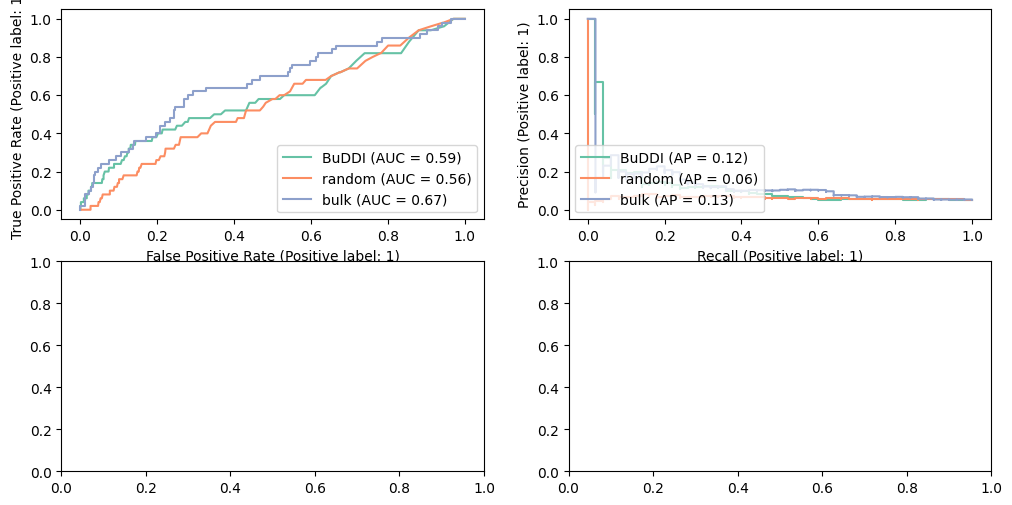

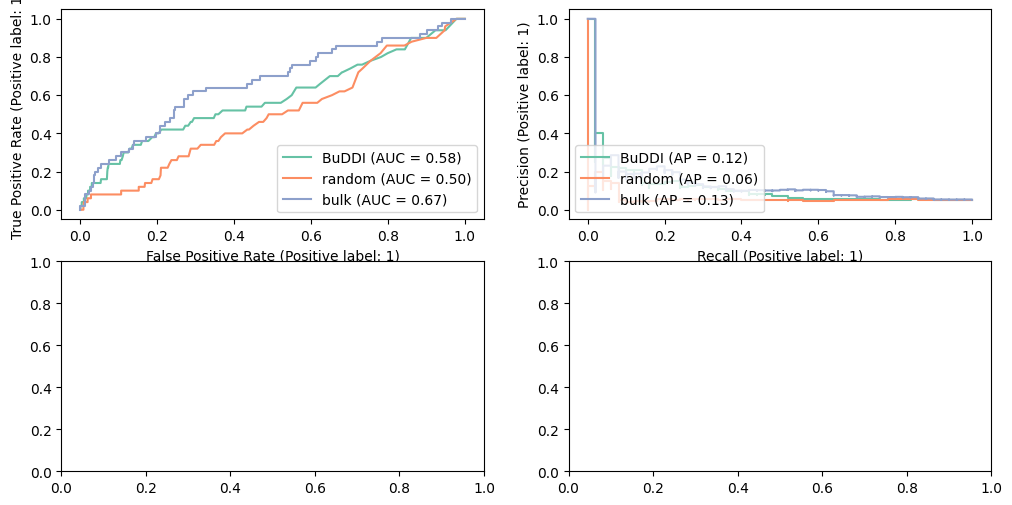

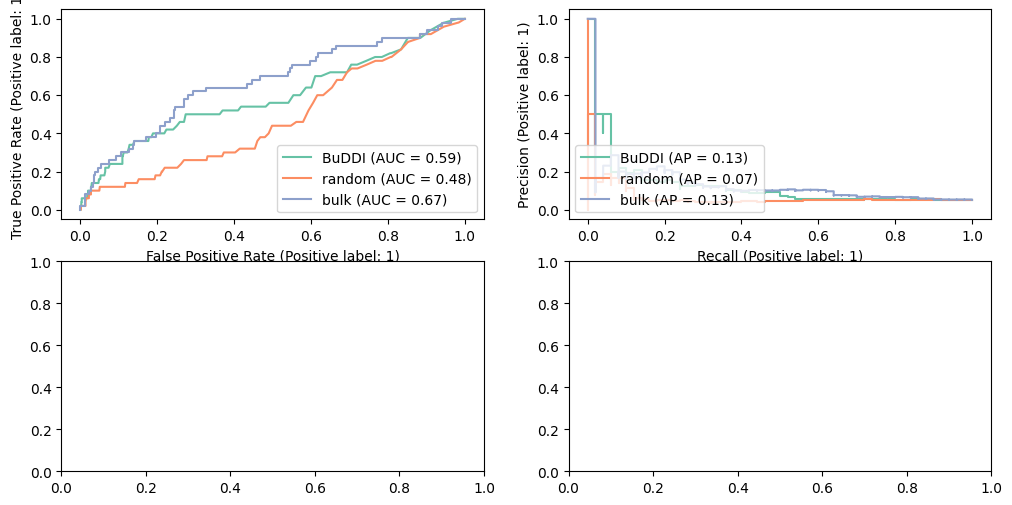

In [151]:

# get PR curve

curr_cell_type = "A549"
all_cell_types = ["A549"]


all_res_df = None
curr_idx = 0
for curr_cell_type in all_cell_types:

    print(curr_cell_type)

    # get our DE genes
    de_genes_curr = de_genes[curr_cell_type]
    de_genes_curr = gene_df
    if de_genes_curr is not None:
        de_genes_curr = [x.upper() for x in de_genes_curr]


    # get bulk DE genes

    # set the reference genes
    ct_DE_ref = de_genes

    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = plot_PR_ROC(res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, 
                                        bulk_sig_df, curr_cell_type, de_genes,
                                        axs, gene_df)

    res_df["run_id"] = 1
    all_res_df = pd.concat([all_res_df, res_df])
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = plot_PR_ROC(res2_meta_df, res2_decoded_0_0, res2_decoded_0_1, 
                                        bulk_sig_df, curr_cell_type, de_genes,
                                        axs, gene_df)

    res_df["run_id"] = 2
    all_res_df = pd.concat([all_res_df, res_df])
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs, proj_log2FC_df, res_df = plot_PR_ROC(res3_meta_df, res3_decoded_0_0, res3_decoded_0_1, 
                                        bulk_sig_df, curr_cell_type, de_genes,
                                        axs, gene_df)

    res_df["run_id"] = 3
    all_res_df = pd.concat([all_res_df, res_df])
    

    curr_idx = curr_idx + 1


NameError: name 'extra_ref' is not defined

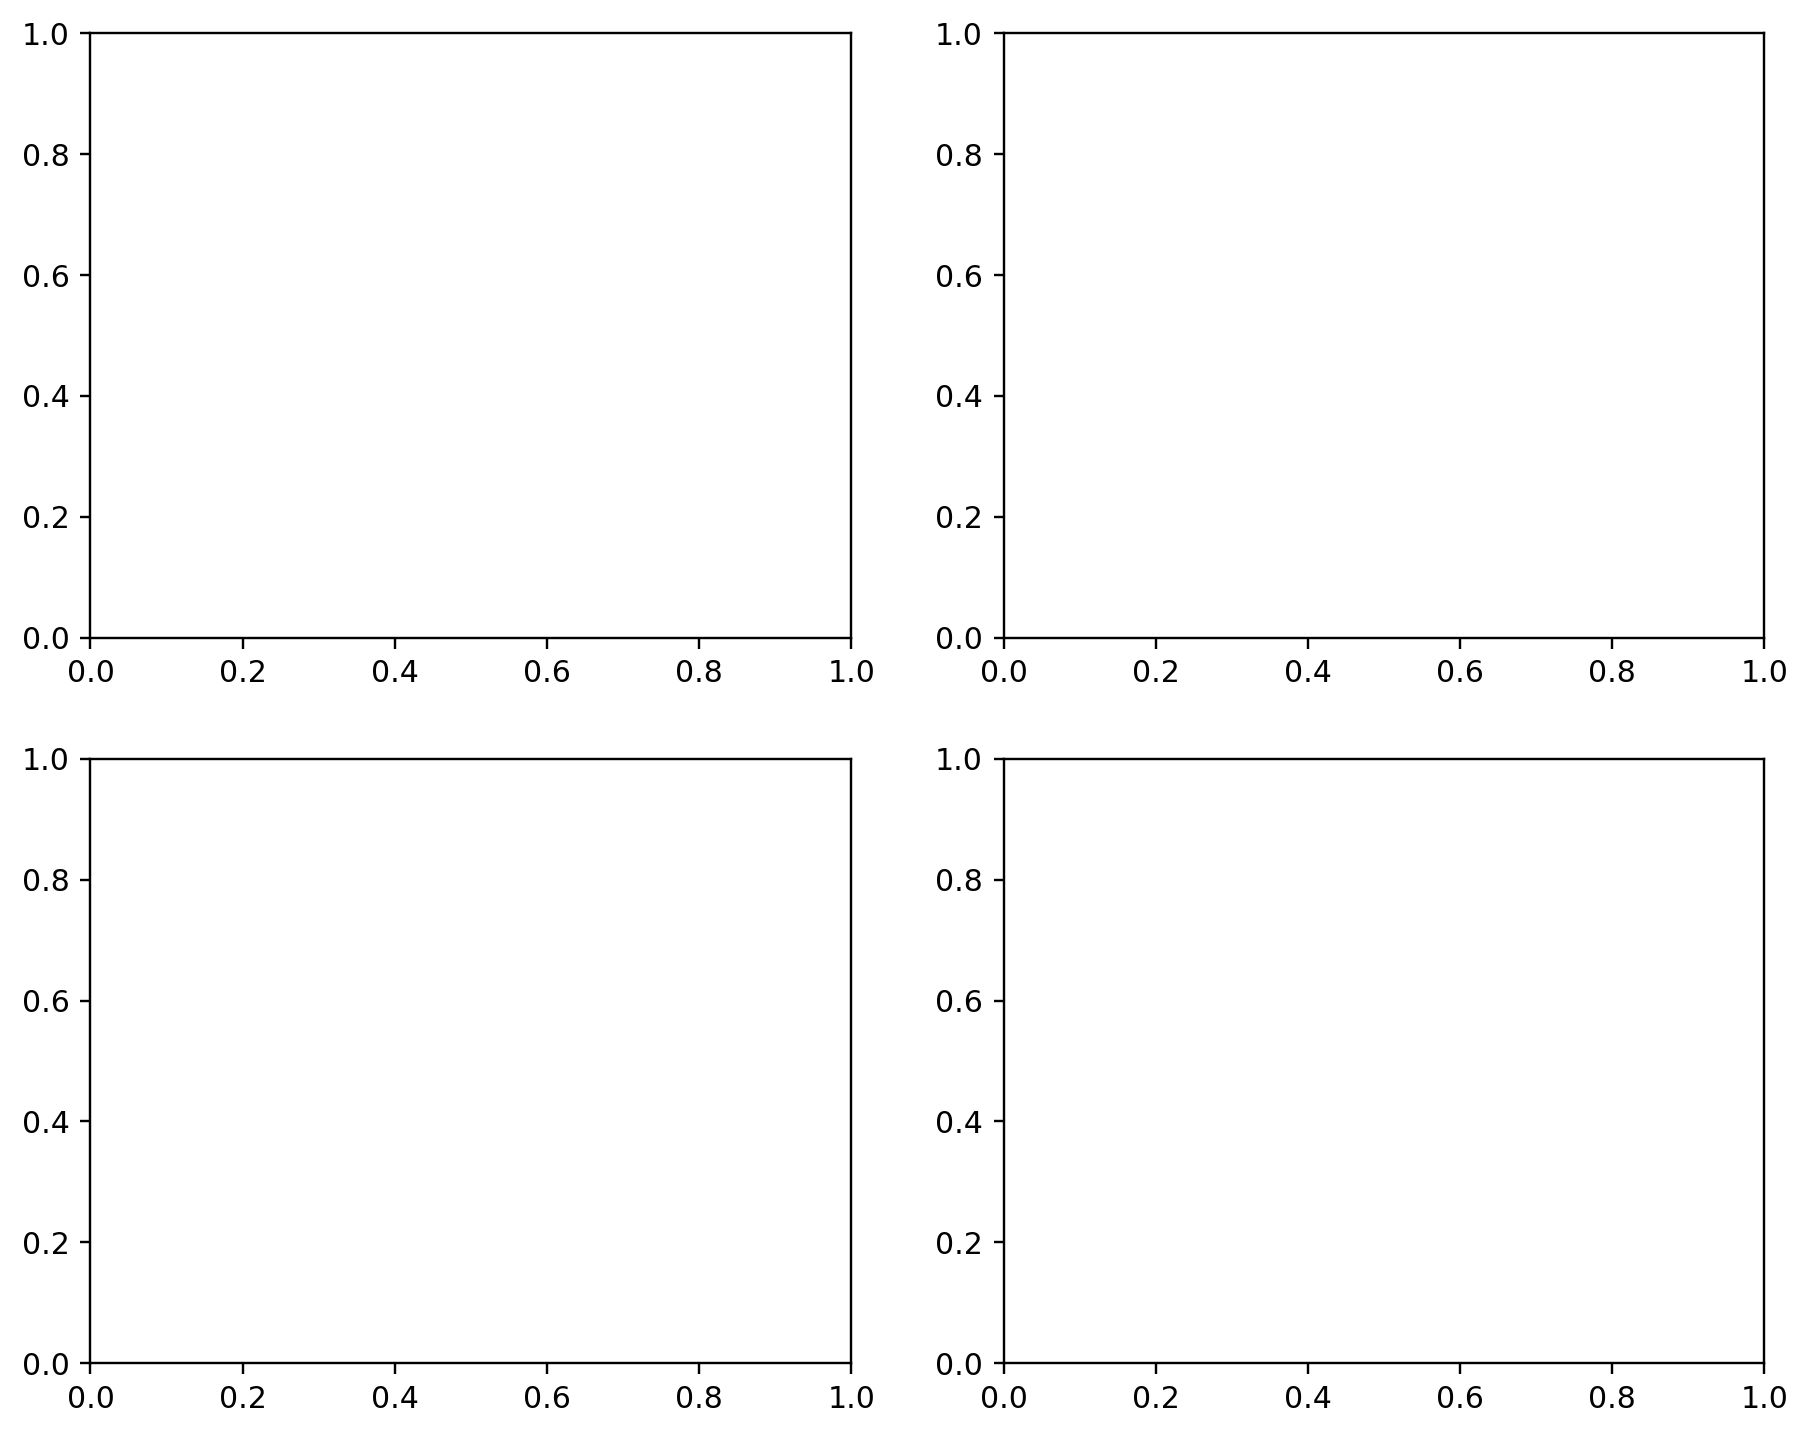

In [152]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=216)
axs, proj_log2FC_df, res_df = vp.plot_PR_ROC_liver(res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, 
                                    bulk_sig_df, "hepatocyte", ct_DE_ref, extra_ref, 
                                    axs, union_genes_cap, method_name="BuDDI")


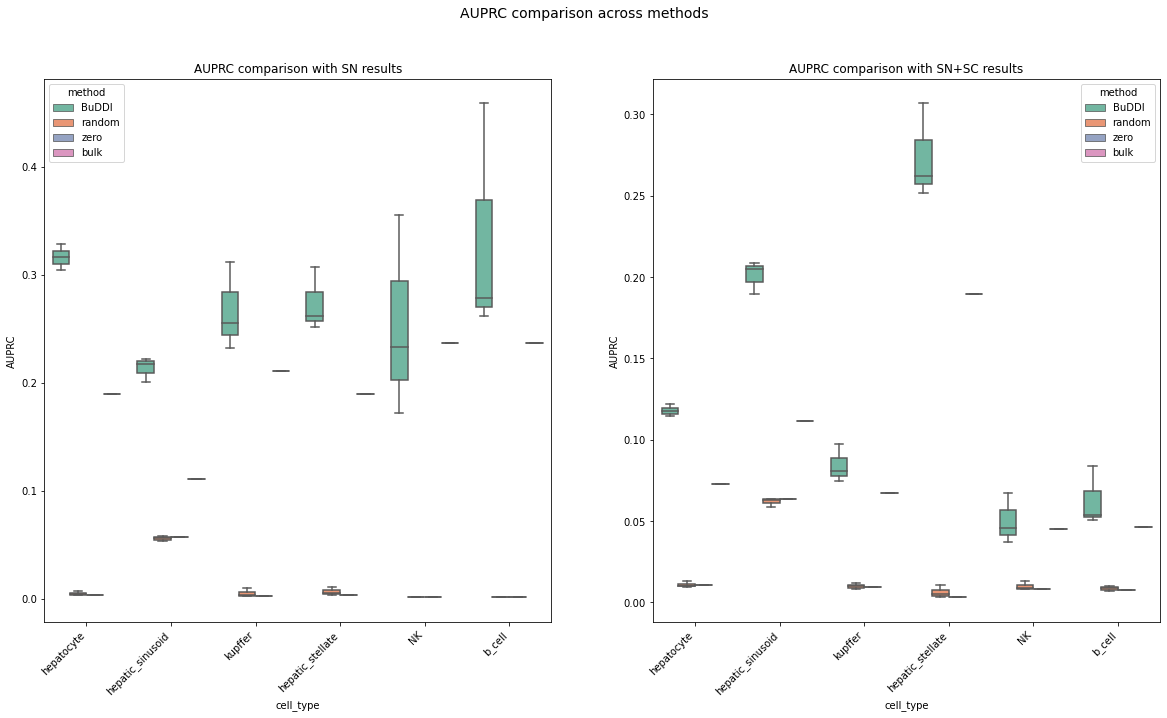

In [ ]:

# plot
fig, axs = plt.subplots(1, 2, figsize=(20,10))

sns.boxplot(data=all_res_df[all_res_df["ref_set"] == "sn"], 
            x="cell_type", y="scores",
            hue="method", ax= axs[0])
axs[0].set_title("AUPRC comparison with SN results")
axs[0].set(ylabel="AUPRC")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.boxplot(data=all_res_df[all_res_df["ref_set"] == "sc_sn"], 
            x="cell_type", y="scores",
            hue="method", ax= axs[1])
axs[1].set_title("AUPRC comparison with SN+SC results")
axs[1].set(ylabel="AUPRC")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle("AUPRC comparison across methods", fontsize=14)

fig.show()



In [ ]:
all_res_df

scores  metric   cell_type ref_set  method  run_id
0   0.304056  avg_pr  hepatocyte      sn   BuDDI       1
1   0.003919  avg_pr  hepatocyte      sn  random       1
2   0.003571  avg_pr  hepatocyte      sn    zero       1
3   0.189614  avg_pr  hepatocyte      sn    bulk       1
4   0.114471  avg_pr  hepatocyte   sc_sn   BuDDI       1
..       ...     ...         ...     ...     ...     ...
3   0.236744  avg_pr      b_cell      sn    bulk       3
4   0.053777  avg_pr      b_cell   sc_sn   BuDDI       3
5   0.006769  avg_pr      b_cell   sc_sn  random       3
6   0.007714  avg_pr      b_cell   sc_sn    zero       3
7   0.046244  avg_pr      b_cell   sc_sn    bulk       3

[144 rows x 6 columns]

### write out results table

In [ ]:
out_res_path = Path(f"{res_data_path}/BuDDI_auprc.csv")  

all_res_df.to_csv(out_res_path)  